# Project Title: Weather Condition Prediction Using Hidden Markov Models (HMM)

## Install-Import

In [1]:
!pip install gdown
!pip install hmmlearn
!pip install spacy
!python -m spacy download en_core_web_md


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import spacy



## Dataset

In [26]:

#https://drive.google.com/file/d/18Fty4g9-ESAxg0YgHmzi7cUGYK_WNVbB/view?usp=sharing
# File ID and destination path
file_id = '18Fty4g9-ESAxg0YgHmzi7cUGYK_WNVbB'  # Replace with your file ID
output_path = 'weather_data.csv'  # Desired filename

# Download the file
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

# Load the dataset
df = pd.read_csv(output_path)




Downloading...
From: https://drive.google.com/uc?id=18Fty4g9-ESAxg0YgHmzi7cUGYK_WNVbB
To: /content/weather_data.csv
100%|██████████| 463k/463k [00:00<00:00, 6.67MB/s]


## Preprocessing

### Check for missing values

In [30]:
# Count nulls per column
null_counts = df.isnull().sum()
print("\nNull values per column:\n", null_counts)


Null values per column:
 Date/Time           0
Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
Weather             0
dtype: int64


### Check for Duplicates

In [ ]:
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicate rows: 0


### Feature Engineering

#### Add Month and Season Feature

In [4]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Extract month
df['Month'] = df['Date/Time'].dt.month

# Define a function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4

# Apply the function to the 'Month' column
df['Season'] = df['Month'].apply(get_season)



In [5]:
# Display the updated DataFrame
df

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather,Month,Season
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog,1,1
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog,1,1
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog",1,1
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog",1,1
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog,1,1
...,...,...,...,...,...,...,...,...,...,...
8779,2012-12-31 19:00:00,0.1,-2.7,81,30,9.7,100.13,Snow,12,1
8780,2012-12-31 20:00:00,0.2,-2.4,83,24,9.7,100.03,Snow,12,1
8781,2012-12-31 21:00:00,-0.5,-1.5,93,28,4.8,99.95,Snow,12,1
8782,2012-12-31 22:00:00,-0.2,-1.8,89,28,9.7,99.91,Snow,12,1


#### Mapping
mapping rare weather conditions to Most Frequent and Similar weather condition in that season

##### Extract unique weather classes

In [32]:
#Extract unique weather classes
unique_weather_classes = df['Weather'].unique()

#Display the unique weather classes
print("Unique weather classes:")
for weather in unique_weather_classes:
    print(weather)
count_unique_weather_classes = len(df['Weather'].unique())

# Display the unique weather classes
print("Unique weather classes:")
print(count_unique_weather_classes)

Unique weather classes:
Fog
Freezing Drizzle,Fog
Mostly Cloudy
Cloudy
Rain
Rain Showers
Mainly Clear
Snow Showers
Snow
Clear
Freezing Rain,Fog
Freezing Rain
Freezing Drizzle
Rain,Snow
Moderate Snow
Freezing Drizzle,Snow
Freezing Rain,Snow Grains
Snow,Blowing Snow
Freezing Fog
Haze
Rain,Fog
Drizzle,Fog
Drizzle
Freezing Drizzle,Haze
Freezing Rain,Haze
Snow,Haze
Snow,Fog
Snow,Ice Pellets
Rain,Haze
Thunderstorms,Rain
Thunderstorms,Rain Showers
Thunderstorms,Heavy Rain Showers
Thunderstorms,Rain Showers,Fog
Thunderstorms
Thunderstorms,Rain,Fog
Thunderstorms,Moderate Rain Showers,Fog
Rain Showers,Fog
Rain Showers,Snow Showers
Snow Pellets
Rain,Snow,Fog
Moderate Rain,Fog
Freezing Rain,Ice Pellets,Fog
Drizzle,Ice Pellets,Fog
Drizzle,Snow
Rain,Ice Pellets
Drizzle,Snow,Fog
Rain,Snow Grains
Rain,Snow,Ice Pellets
Snow Showers,Fog
Moderate Snow,Blowing Snow
Unique weather classes:
50


##### Calculate top weather conditions for each season based on the 97% cumulative threshold

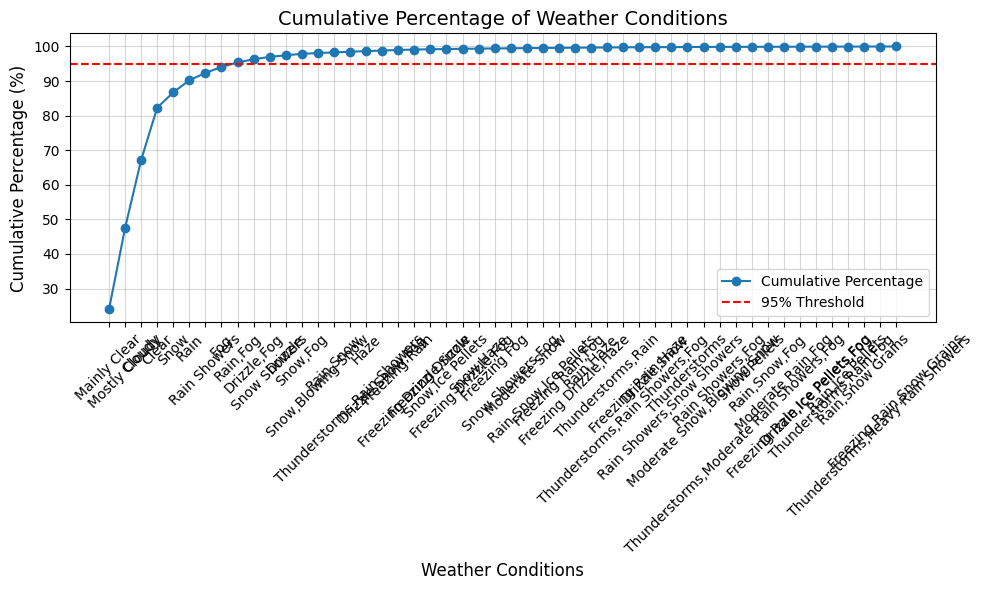

Top weather condition frequencies: ['Cloudy', 'Clear', 'Snow', 'Rain', 'Rain Showers', 'Fog']


In [33]:
# Calculate frequency of weather conditions
weather_counts = df["Weather"].value_counts()
cumulative_percentage = weather_counts.cumsum() / weather_counts.sum() * 100

# Select weather conditions within the 95% cumulative percentage
top_weather = cumulative_percentage[cumulative_percentage <= 95].index.tolist()

# Plot cumulative percentage
plt.figure(figsize=(10, 6))
plt.plot(cumulative_percentage.index, cumulative_percentage.values, marker='o', label='Cumulative Percentage')
plt.axhline(y=95, color='r', linestyle='--', label='95% Threshold')

# Highlight the top weather conditions
plt.xticks(rotation=45)
plt.title('Cumulative Percentage of Weather Conditions', fontsize=14)
plt.xlabel('Weather Conditions', fontsize=12)
plt.ylabel('Cumulative Percentage (%)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

# top_weather
top_weather.remove('Mainly Clear')
top_weather.remove('Mostly Cloudy')
# 'Mostly Cloudy'
# Log the results
print(f"Top weather condition frequencies: {top_weather}")


##### Create a mapping from other weathers to top weathers

In [34]:
# Load a language model (e.g., spaCy)
nlp = spacy.load("en_core_web_md")

# Example of frequent and infrequent weather conditions
frequent_conditions = top_weather  # The top weather conditions from earlier
all_conditions = df["Weather"].unique()  # All unique weather conditions

# Map each infrequent condition to the most similar frequent condition
weather_mapping = {}
for condition in all_conditions:
    if condition == 'Mostly Cloudy':
        weather_mapping[condition] = 'Cloudy'
    elif condition == 'Mainly Clear':
        weather_mapping[condition] = 'Clear'
    elif condition in frequent_conditions:
        weather_mapping[condition] = condition
    else:
        # Calculate similarity with frequent conditions
        similarities = [
            (freq, nlp(condition).similarity(nlp(freq)))
            for freq in frequent_conditions
        ]
        # Map to the most similar frequent condition
        most_similar = max(similarities, key=lambda x: x[1])[0]
        weather_mapping[condition] = most_similar

# Apply the mapping to the DataFrame
df["Mapped_Weather"] = df["Weather"].map(weather_mapping)

# Print the mapping for review
print("Weather Condition Mapping:")
for original, mapped in weather_mapping.items():
    print(f"{original} -> {mapped}")


Weather Condition Mapping:
Fog -> Fog
Freezing Drizzle,Fog -> Rain Showers
Mostly Cloudy -> Cloudy
Cloudy -> Cloudy
Rain -> Rain
Rain Showers -> Rain Showers
Mainly Clear -> Clear
Snow Showers -> Rain Showers
Snow -> Snow
Clear -> Clear
Freezing Rain,Fog -> Rain
Freezing Rain -> Rain
Freezing Drizzle -> Rain Showers
Rain,Snow -> Snow
Moderate Snow -> Snow
Freezing Drizzle,Snow -> Snow
Freezing Rain,Snow Grains -> Snow
Snow,Blowing Snow -> Snow
Freezing Fog -> Rain
Haze -> Rain
Rain,Fog -> Rain
Drizzle,Fog -> Rain
Drizzle -> Cloudy
Freezing Drizzle,Haze -> Rain Showers
Freezing Rain,Haze -> Rain
Snow,Haze -> Snow
Snow,Fog -> Snow
Snow,Ice Pellets -> Snow
Rain,Haze -> Rain
Thunderstorms,Rain -> Rain
Thunderstorms,Rain Showers -> Rain Showers
Thunderstorms,Heavy Rain Showers -> Rain Showers
Thunderstorms,Rain Showers,Fog -> Rain Showers
Thunderstorms -> Rain Showers
Thunderstorms,Rain,Fog -> Rain
Thunderstorms,Moderate Rain Showers,Fog -> Rain Showers
Rain Showers,Fog -> Rain Showers
Rain

In [35]:
count_unique_weather_classes = len(df['Mapped_Weather'].unique())

# Display the unique weather classes
print("Unique weather classes:")
print(count_unique_weather_classes)

Unique weather classes:
6


#### Adding Temprature change feature

In [10]:
# Create new columns for temperature shifts
df['Temp_1h_ago'] = df['Temp_C'].shift(1)
df['Temp_2h_ago'] = df['Temp_C'].shift(2)
df['Temp_3h_ago'] = df['Temp_C'].shift(3)

# Calculate the temperature changes
df['Temp_Change_1h'] = df['Temp_C'] - df['Temp_1h_ago']
df['Temp_Change_2h'] = df['Temp_C'] - df['Temp_2h_ago']
df['Temp_Change_3h'] = df['Temp_C'] - df['Temp_3h_ago']

# Handle NaN values for the first few rows (optional)
df.fillna(0, inplace=True)  # Replace with dropna() if preferred


In [11]:
# Create new columns for wind speed shifts
df['Wind_Speed_1h_ago'] = df['Wind Speed_km/h'].shift(1)
df['Wind_Speed_2h_ago'] = df['Wind Speed_km/h'].shift(2)
df['Wind_Speed_3h_ago'] = df['Wind Speed_km/h'].shift(3)

# Calculate the wind speed changes
df['Wind_Change_1h'] = df['Wind Speed_km/h'] - df['Wind_Speed_1h_ago']
df['Wind_Change_2h'] = df['Wind Speed_km/h'] - df['Wind_Speed_2h_ago']
df['Wind_Change_3h'] = df['Wind Speed_km/h'] - df['Wind_Speed_3h_ago']

# Handle NaN values for the first few rows (optional)
df.fillna(0, inplace=True)  # Replace with dropna() if preferred


In [12]:
# Create new columns for pressure shifts
df['Pressure_1h_ago'] = df['Press_kPa'].shift(1)
df['Pressure_2h_ago'] = df['Press_kPa'].shift(2)
df['Pressure_3h_ago'] = df['Press_kPa'].shift(3)

# Calculate the pressure changes
df['Pressure_Change_1h'] = df['Press_kPa'] - df['Pressure_1h_ago']
df['Pressure_Change_2h'] = df['Press_kPa'] - df['Pressure_2h_ago']
df['Pressure_Change_3h'] = df['Press_kPa'] - df['Pressure_3h_ago']

# Handle NaN values for the first few rows (optional)
df.fillna(0, inplace=True)  # Replace with dropna() if preferred

### Label Encoding

In [36]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
df['Weather_State'] = label_encoder.fit_transform(df['Mapped_Weather'])


### Remove Outliers

In [14]:
### Remove Outliers
# Select numerical columns
numerical_cols = ['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa']

# Function to remove outliers using Z-score
def remove_outliers_zscore(data, columns, threshold=3):
    z_scores = np.abs((data[columns] - data[columns].mean()) / data[columns].std())
    # Retain rows where all Z-scores are below the threshold
    filtered_data = data[(z_scores < threshold).all(axis=1)]
    return filtered_data

# Remove outliers
cleaned_df = remove_outliers_zscore(df, numerical_cols)

print("Original dataset size:", df.shape)
print("Dataset size after removing outliers:", cleaned_df.shape)
df = cleaned_df


Original dataset size: (8784, 30)
Dataset size after removing outliers: (8656, 30)


## Model Implementation and Train

### Analyze data distribution

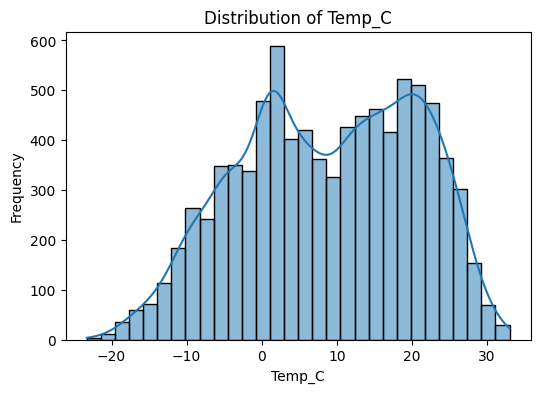

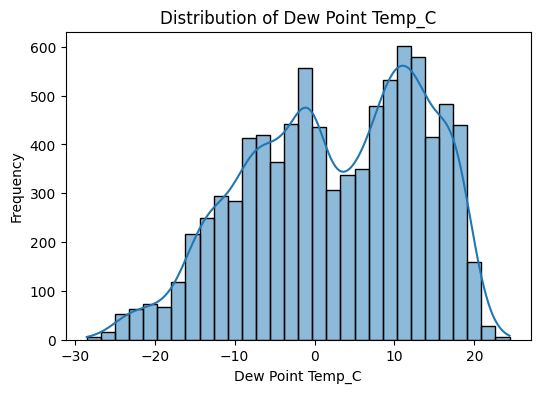

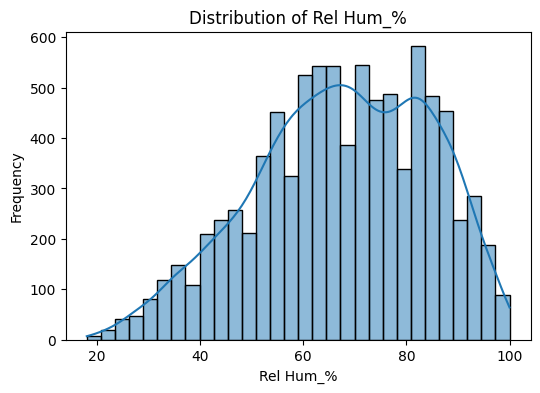

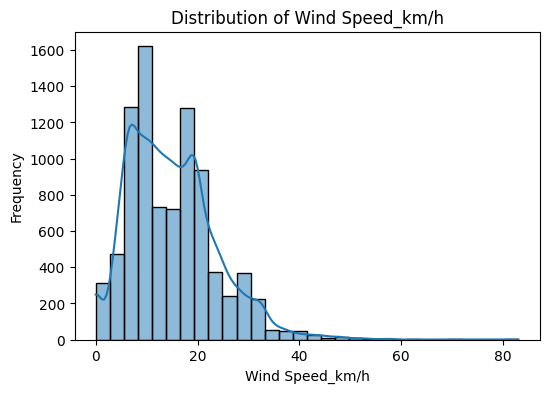

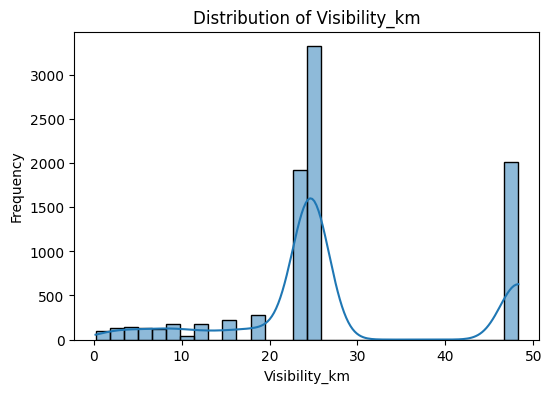

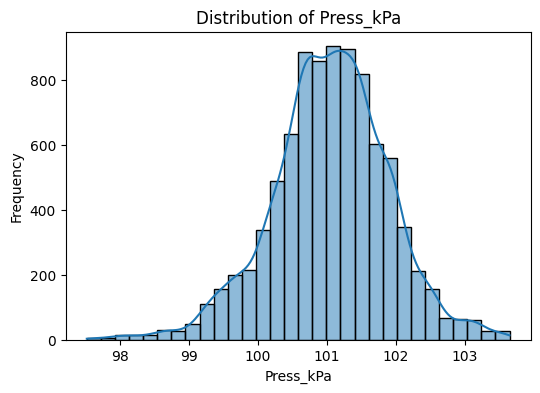

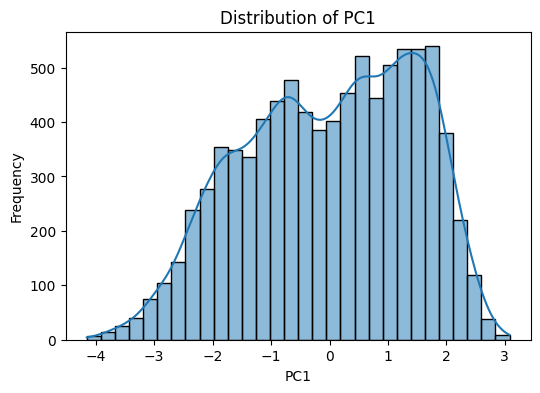

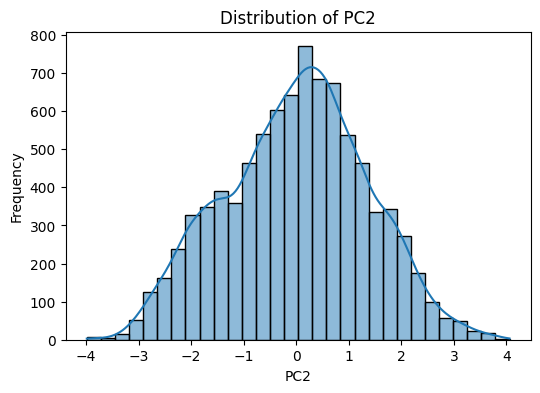

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example DataFrame (replace with your actual dataset)
# df = pd.read_csv('your_dataset.csv')

# Step 1: Plot distribution of numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Step 2: Perform PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_columns])  # Scale the numerical data
pca = PCA(n_components=2)  # Set n_components based on desired dimensionality
pca_result = pca.fit_transform(df_scaled)

# Step 3: Plot distribution of PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

for col in pca_df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(pca_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


### Train-Test Split

In [15]:
# Initialize empty lists to store train-test splits
X_train, X_test, y_train, y_test = [], [], [], []

# Iterate over each season and split chronologically
for season in df['Season'].unique():
    season_data = df[df['Season'] == season]

    # Split features and target
    X = season_data[['Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa','Month','Season','Temp_Change_1h','Temp_Change_2h']].values

    y = season_data['Weather_State'].values
    # Determine split point
    train_size = int(0.8 * len(season_data))

    # Split into train and test sets
    X_train.extend(X[:train_size])
    X_test.extend(X[train_size:])
    y_train.extend(y[:train_size])
    y_test.extend(y[train_size:])


### HMM Configuration

Testing with n_components=4, n_iter=25
Accuracy: 0.19676860934795154
Testing with n_components=4, n_iter=50
Accuracy: 0.19676860934795154
Testing with n_components=4, n_iter=75
Accuracy: 0.19676860934795154
Testing with n_components=4, n_iter=100
Accuracy: 0.19676860934795154
Testing with n_components=5, n_iter=25
Accuracy: 0.1829197922677438
Testing with n_components=5, n_iter=50
Accuracy: 0.1829197922677438
Testing with n_components=5, n_iter=75
Accuracy: 0.1829197922677438
Testing with n_components=5, n_iter=100
Accuracy: 0.1829197922677438
Testing with n_components=6, n_iter=25
Accuracy: 0.395268320830929
Testing with n_components=6, n_iter=50
Accuracy: 0.40507789959607615
Testing with n_components=6, n_iter=75


Accuracy: 0.2567801500288517
Testing with n_components=6, n_iter=100


Accuracy: 0.2567801500288517
Testing with n_components=7, n_iter=25
Accuracy: 0.058857472590882864
Testing with n_components=7, n_iter=50
Accuracy: 0.05539526832083093
Testing with n_components=7, n_iter=75
Accuracy: 0.05539526832083093
Testing with n_components=7, n_iter=100
Accuracy: 0.05539526832083093
Testing with n_components=8, n_iter=25
Accuracy: 0.10213502596653203
Testing with n_components=8, n_iter=50
Accuracy: 0.08482400461627236
Testing with n_components=8, n_iter=75
Accuracy: 0.08482400461627236
Testing with n_components=8, n_iter=100
Accuracy: 0.08482400461627236
Best configuration: n_components=6, n_iter=50 and Accuracy: 0.40507789959607615


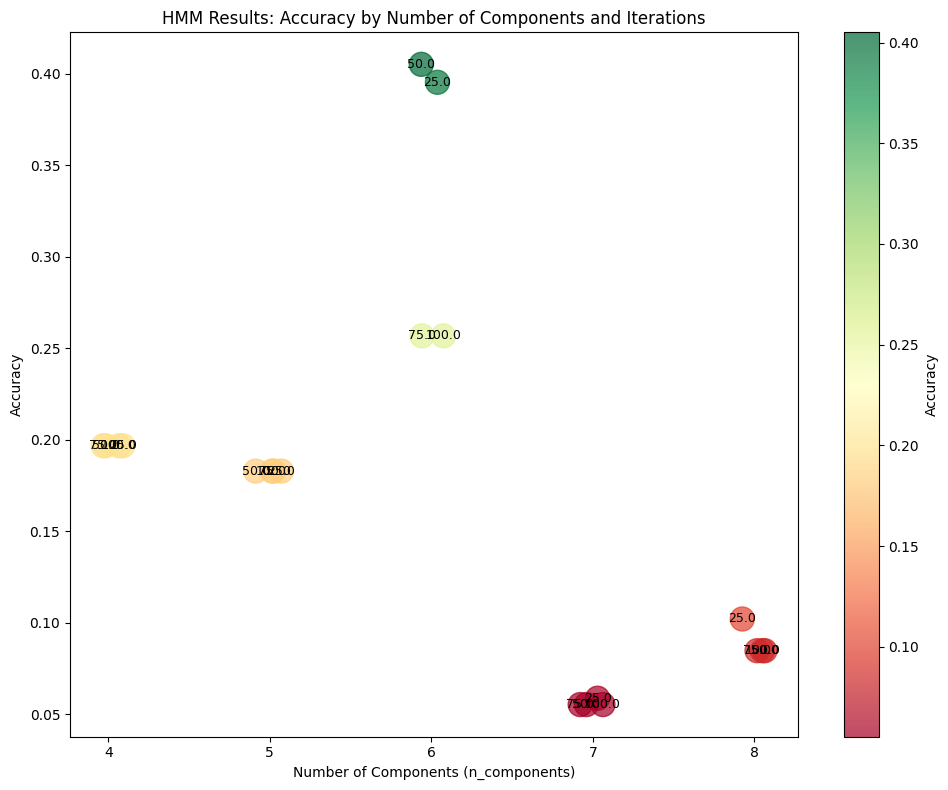

In [16]:
# Define ranges for `n_components` and `n_iter`
n_components_list = range(4, 9)  # Test from 4 to 8 hidden states
n_iter_list = [25, 50, 75, 100]  # Test for different iteration counts (removed 10000)
results = []

for n_components in n_components_list:
    for n_iter in n_iter_list:
        print(f"Testing with n_components={n_components}, n_iter={n_iter}")
        try:
            # Initialize and fit the HMM model
            model = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=n_iter, random_state=42, tol=0.02)
            model.fit(X_train)

            # Predict states for the test data
            y_pred = model.predict(X_test)

            # Calculate accuracy (if ground truth is available)
            accuracy = accuracy_score(y_test, y_pred)

            print(f"Accuracy: {accuracy}")

            # Store results
            results.append({
                "n_components": n_components,
                "n_iter": n_iter,
                "accuracy": accuracy
            })
        except Exception as e:
            print(f"Error with n_components={n_components}, n_iter={n_iter}: {e}")
            results.append({
                "n_components": n_components,
                "n_iter": n_iter,
                "accuracy": None
            })

# Save data to a CSV file
df = pd.DataFrame(results)

# Sort results by accuracy
sorted_results = sorted(results, key=lambda x: x["accuracy"] or float('-inf'), reverse=True)

# Display best result
best_result = sorted_results[0]
print(f"Best configuration: n_components={best_result['n_components']}, "
      f"n_iter={best_result['n_iter']} and Accuracy: {best_result['accuracy']}")

# Scatter plot
plt.figure(figsize=(10, 8))

# Add jitter to `n_components` to avoid overlapping points
def add_jitter(values, jitter_amount=0.1):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=len(values))

df['n_components_jittered'] = add_jitter(df['n_components'])

sc = plt.scatter(
    x=df['n_components_jittered'],
    y=df['accuracy'],
    c=df['accuracy'],
    s=300,  # Increased size for better visibility
    cmap='RdYlGn',  # Green for better accuracy, red for worse
    alpha=0.7
)
for i, row in df.iterrows():
    plt.text(row['n_components_jittered'], row['accuracy'], str(row['n_iter']), fontsize=9, ha='center', va='center')
plt.colorbar(sc, label='Accuracy')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Accuracy')
plt.title('HMM Results: Accuracy by Number of Components and Iterations')
plt.tight_layout()
plt.show()


## Evaluation and Visualisation

### Retrain and Fit mode with the best parameters

In [47]:
# Refit the best model with optimal parameters
best_n_components = best_result['n_components']
best_n_iter = best_result['n_iter']

# Initialize and train the model
best_model = GaussianHMM(n_components=best_n_components, covariance_type='diag', n_iter=best_n_iter, random_state=42)

# fit the model
best_model.fit(X_train)

#predict test data
y_pred = best_model.predict(X_test)



### F1 Score - Recall - Accuracy

In [23]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Evaluate the accuracy, F1-score, and recall
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class or imbalanced classes
recall = recall_score(y_test, y_pred, average='weighted')  # Same averaging method

# Print results with two decimal precision
print(f"Accuracy of HMM model: {accuracy:.2f}")
print(f"F1-score of HMM model: {f1:.2f}")
print(f"Recall of HMM model: {recall:.2f}")


Accuracy of HMM model: 0.41
F1-score of HMM model: 0.37
Recall of HMM model: 0.41


### Confusion Matrix

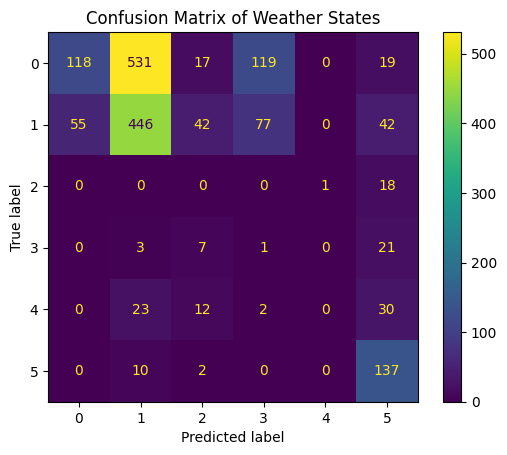

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate and display a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Confusion Matrix of Weather States")
plt.show()


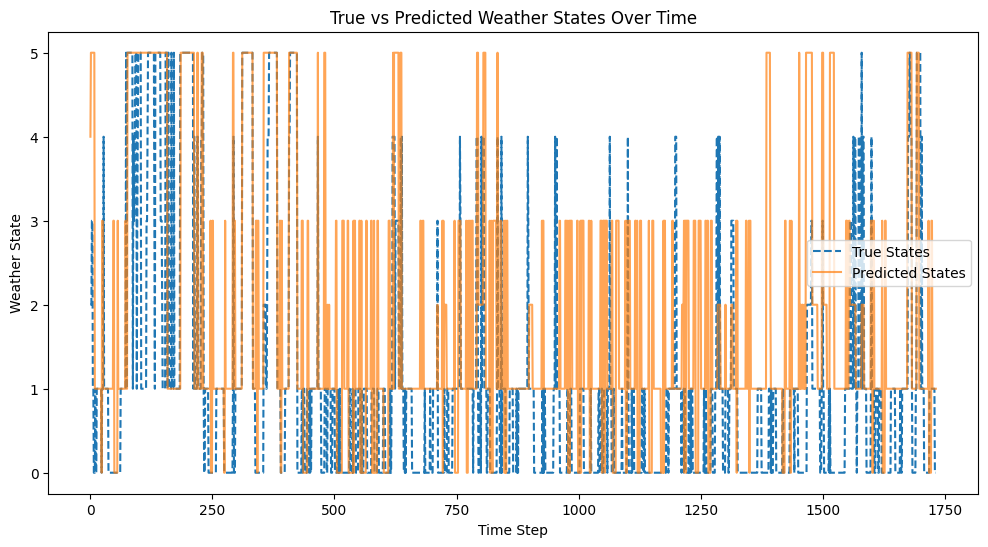

In [38]:
# Compare sequences of predicted states against true states
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="True States", linestyle='--')
plt.plot(y_pred, label="Predicted States", alpha=0.7)
plt.title("True vs Predicted Weather States Over Time")
plt.xlabel("Time Step")
plt.ylabel("Weather State")
plt.legend()
plt.show()


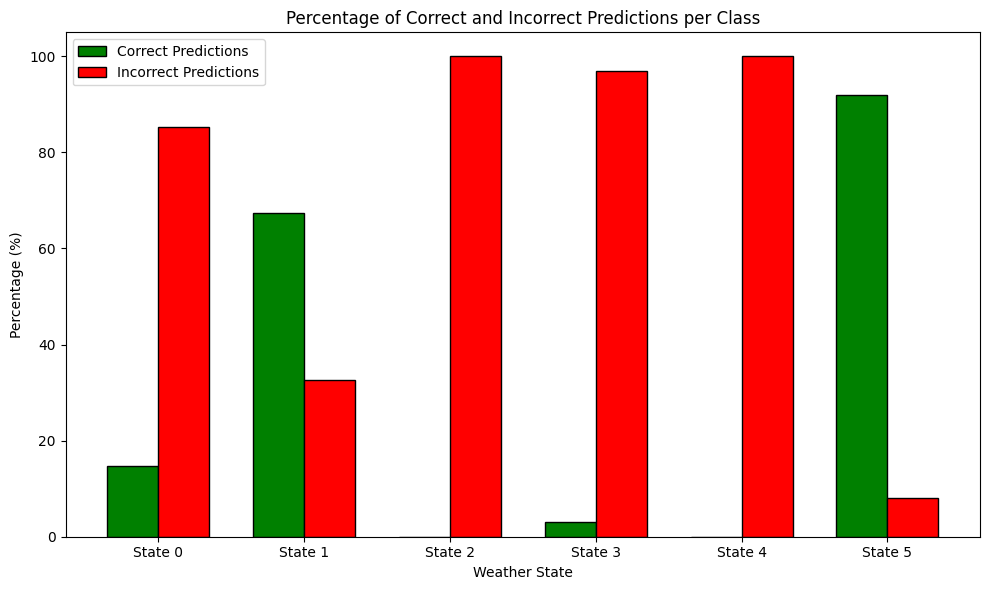

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get the unique classes from the true labels (y_test)
n_classes = len(np.unique(y_test))

# Get the confusion matrix from the best model
cm = confusion_matrix(y_test, y_pred)

# Calculate correct and incorrect predictions per class
correct_per_class = np.diagonal(cm)  # Correct predictions (diagonal of the confusion matrix)
incorrect_per_class = np.sum(cm, axis=1) - correct_per_class  # Incorrect predictions (row sum minus diagonal)

# Calculate percentages for correct and incorrect predictions
correct_percentages = correct_per_class / np.sum(cm, axis=1) * 100
incorrect_percentages = incorrect_per_class / np.sum(cm, axis=1) * 100

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width for each class
bar_width = 0.35

# x positions for the bars
x = np.arange(n_classes)

# Plot the correct percentages (green bars)
ax.bar(x - bar_width / 2, correct_percentages, bar_width, color='green', edgecolor='black', label='Correct Predictions')

# Plot the incorrect percentages (red bars)
ax.bar(x + bar_width / 2, incorrect_percentages, bar_width, color='red', edgecolor='black', label='Incorrect Predictions')

# Adding labels and title
ax.set_title("Percentage of Correct and Incorrect Predictions per Class")
ax.set_xlabel("Weather State")
ax.set_ylabel("Percentage (%)")
ax.set_xticks(x)
ax.set_xticklabels([f"State {i}" for i in range(n_classes)])
ax.legend()

plt.tight_layout()
plt.show()
